# Swirl correction
The purpose of the project is to identify and correct the portion of the input image affected by a moderate swirl effect.

The center, radius and intensity of the swirl is variable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import swirl, resize
from skimage.draw import disk
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

2025-07-10 10:13:07.475165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 10:13:07.483456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752135187.492107    9276 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752135187.494697    9276 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752135187.502330    9276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

We work on a medium resolution dataset of natural images

In [2]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [3]:
# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32  # max pixel radius of swirl defect
STRENGTH = 4 #max swirl strength

Let us slightly reduce

In [4]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

The following function generate a different swirl effect for each image.

In [5]:
def generate_swirl_defect(image_np):
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

Here is a simple generator. Feel free to adapt it to your needs.
*   you cannot pass the mask as input to the network (but you may try to predict it, if you want)
*   you may regenerate the swirl dynamically at each epoch for data augmentation priurposes, if required.



In order to increase the robustness and generalization capability of the model, I added a data augmentation pipeline within the `SwirlDefectGenerator`.
This augmentation is applied only when the `augment` flag is set to `True`, this way I can easily switch between training and validation/testing modes. As a matter of fact, I do not want to augment the validation/testing data, as I want to evaluate the model on the original images, I just want to augment the training data.

I added the following augmentations:
*   random horizontal flip
*   random rotation
*   random zoom
*   random contrast adjustment

In [6]:
# === DATA GENERATOR ===
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True, res="all", augment=True):
        self.images = images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.res = res
        self.augment = augment
        if self.augment:
            self.augmenter = tf.keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.2),
                layers.RandomZoom(0.2),
                layers.RandomContrast(0.2),
            ])

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_clean = self.images[batch_indices]
        batch_defected = []
        batch_masks = []

        if self.augment:
            batch_clean = self.augmenter(batch_clean).numpy()

        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected.append(swirled)
            batch_masks.append(mask)
        if self.res == "all":
            return np.array(batch_defected), np.array(batch_masks), np.array(batch_clean)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [7]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image) #.take(num_train + num_val + num_test)
    all_images = tf.stack(list(ds))
    print(len(all_images))
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

As said before, the augmentation is applied only when the `augment` flag is set to `True`, in this case the only generator augmented will be the training one, while the validation and testing generators will not be augmented.

In [8]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = SwirlDefectGenerator(train_imgs, batch_size=32, res="all", augment=True)
val_gen = SwirlDefectGenerator(val_imgs, batch_size=32, res="all", augment=False)
test_gen = SwirlDefectGenerator(test_imgs, batch_size=32, res="all", augment=False)

I0000 00:00:1752135189.047058    9276 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-07-10 10:13:09.172045: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-10 10:13:09.561613: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3670


(32, 128, 128, 3)


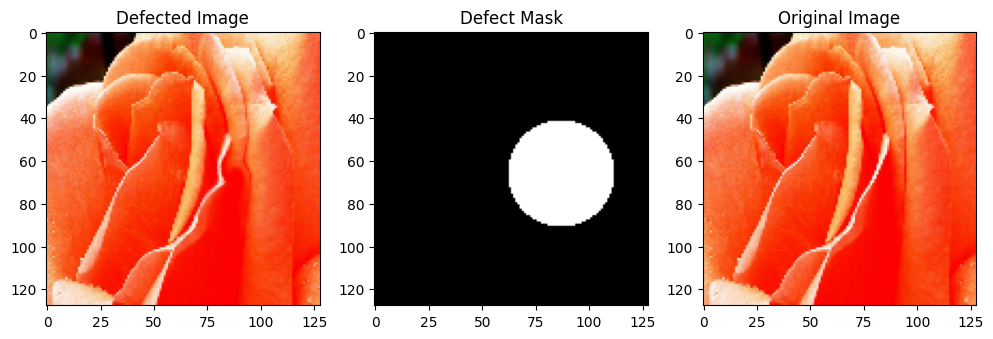

In [9]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
x_batch, y_mask, y_clean = test_gen[idx]
print(y_clean.shape)
y_clean = y_clean[:,:,:,0:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch[0])
plt.title("Defected Image")

plt.subplot(1, 3, 2)
plt.imshow(y_mask[0].squeeze(), cmap='gray')
plt.title("Defect Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_clean[0])
plt.title("Original Image")
plt.show()


# My Network

In [10]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("No GPU found. Using CPU.")


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


To effectively handle the task of correcting a defected region in an image (not focusing on the fact that it had been applied a swirl effect), I adopted a two-stage pipeline composed by two neural networks:
1. **Mask Detection Network**: This network is responsible for identifying the defected region in the image. It outputs a mask that highlights the area affected by the defect.
2. **Defect Correction Network**: This network takes the original image and the mask generated by the first network as inputs. It is trained to correct the defected region based on the information provided by the mask.

To get the most out of my pipeline it must be trained in order to learn how to detect the defected region and how to correct it.

## Mask Prediction Network
This is the first network in the pipeline, it is responsible for predicting the mask of the defected region in the image.
It uses a U-Net architecture. Its purpose is to **identify the region of the image that contains some sort of defect** by producing a mask that highlights the defected area. The mask indicates the pixels that are affected by the artifact.
A key aspect of this network is its loss function: I used  a custom loss function which computes the **intersection over union (IoU)** between the predicted mask and the ground truth mask. This **IoU-based loss function** really helps the network to focus on the defected region and learn how to accurately predict the mask.
To better understand the performance of the mask prediction network, I also compute the **Dice coefficient** as a metric during the training process to carefully monitor the model's performance over the epochs.
This model has a total of 64,124 parameters of which 1,408 are non-trainable parameters.

## Defect Correction Network
The second network in the pipeline is responsible for **correcting the defected region in the image**.
It takes as input:
- the defected image
- the mask predicted by the first network
This network's architecture is also based on a U-Net, with some key details that helps the model to learn how to correct the defected region:
- the input image is concatenated with the predicted mask, allowing the model to focus on the defected region and learn how to correct it.
- in the network I used residual blocks, which help the model to learn how to correct the defected region by allowing the model to learn the residuals between the defected image and the corrected image.
- two transformer blocks are placed in the bottleneck of the U-Net, which help the model to learn relationships across the image when correcting the defected region.

A really important aspect of this network is its loss function: I used a *custom loss function* which computes the ***masked mean squared error***. this function computes the mean squared error only on the *pixels marked by the defect predicted mask*, allowing the model to:
- focus on the defected region
- avoid penalizing the model for the pixels that are not affected by the defect


I also compute some metrics during the training process to carefully monitor the model's performance over the epochs:
- **masked mean absolute error**: this metric computes the mean absolute error only on the pixels marked by the defect predicted mask, allowing the model to focus on the defected region and learn how to correct it.
- **masked mean squared error**: this metric computes the mean squared error only on the pixels marked by the defect predicted mask, allowing the model to focus on the defected region and learn how to correct it.
- **masked absolute error**: this metric computes the absolute error only on the pixels marked by the defect predicted mask, allowing the model to focus on the defected region and learn how to correct it.


In [11]:
from tensorflow.keras import layers, Model

# Two networks pipeline: the first one predicts the defect mask, the second one tries to correct the defect.

# Architectures


# Mask Predictor
def build_mask_unet(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), base_filters=16, dropout_rate=0.1
):
    inputs = layers.Input(shape=input_shape)

    def conv_block(x, filters, kernel_size=3, padding="same", activation="relu"):
        x = layers.SeparableConv2D(
            filters, kernel_size, padding=padding, use_bias=False
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.SeparableConv2D(
            filters, kernel_size, padding=padding, use_bias=False
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x

    # Encoder
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPool2D()(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = conv_block(p1, base_filters * 2)
    p2 = layers.MaxPool2D()(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = conv_block(p2, base_filters * 4)
    p3 = layers.MaxPool2D()(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    # Bottleneck
    b = conv_block(p3, base_filters * 8)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    u3 = layers.Dropout(dropout_rate)(u3)
    c4 = conv_block(u3, base_filters * 4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Dropout(dropout_rate)(u2)
    c5 = conv_block(u2, base_filters * 2)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Dropout(dropout_rate)(u1)
    c6 = conv_block(u1, base_filters)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c6)

    model = models.Model(inputs, outputs, name="MaskUNet")
    return model

# Correction Model class that inherits from tf.keras.Model
class CorrectionModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

        self.loss_fn = masked_mse_fn
        self.masked_mae_fn = masked_mae_fn

        self.standard_mse = tf.keras.metrics.MeanSquaredError(name="mse")
        self.standard_mae = tf.keras.metrics.MeanAbsoluteError(name="mae")
        self.masked_mae_tracker = tf.keras.metrics.Mean(name="masked_mae")
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)

    def train_step(self, data):
        (x_img, x_mask), y_true = data

        with tf.GradientTape() as tape:
            y_pred = self([x_img, x_mask], training=True)
            loss = masked_mse_fn(y_true, y_pred, x_mask)
            masked_mae = masked_mae_fn(y_true, y_pred, x_mask)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.masked_mae_tracker.update_state(masked_mae)
        self.standard_mse.update_state(y_true, y_pred)
        self.standard_mae.update_state(y_true, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "masked_mae": self.masked_mae_tracker.result(),
            "mse": self.standard_mse.result(),
            "mae": self.standard_mae.result(),
        }

    def test_step(self, data):
        (x_img, x_mask), y_true = data
        y_pred = self([x_img, x_mask], training=False)
        loss = masked_mse_fn(y_true, y_pred, x_mask)
        masked_mae = masked_mae_fn(y_true, y_pred, x_mask)

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.masked_mae_tracker.update_state(masked_mae)
        self.standard_mse.update_state(y_true, y_pred)
        self.standard_mae.update_state(y_true, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "masked_mae": self.masked_mae_tracker.result(),
            "mse": self.standard_mse.result(),
            "mae": self.standard_mae.result(),
        }

# Defect Correction Model
def build_correction_model(
    input_shape_image=(IMG_SIZE, IMG_SIZE, 3),
    input_shape_mask=(IMG_SIZE, IMG_SIZE, 1),
    base_filters=32,
    dropout_rate=0.1,
):

    # Transformer Block
    def transformer_block(inputs, num_heads=4, ff_dim=128):
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=inputs.shape[-1]
        )(x, x)
        x = layers.Add()([x, attn_output])

        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = layers.Dense(ff_dim, activation="gelu")(x2)
        x2 = layers.Dense(inputs.shape[-1])(x2)
        return layers.Add()([x, x2])

    # Residual Block with Depthwise Separable Convolution
    def residual_block(x, filters, kernel_size=3, padding="same", activation="relu"):
        shortcut = x
        x = layers.Conv2D(filters, kernel_size, padding=padding, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

        x = layers.Conv2D(filters, kernel_size, padding=padding, use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding="same", use_bias=False)(
                shortcut
            )
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.Activation(activation)(x)
        return x

    # Inputs
    input_img = layers.Input(shape=input_shape_image, name="defected_image")
    input_mask = layers.Input(shape=input_shape_mask, name="predicted_mask")

    # Concatenate inputs along the channel axis -> (H, W, 4)
    x = layers.Concatenate(axis=-1)([input_img, input_mask])  # (H, W, 4)

    # Encoder
    c1 = residual_block(x, base_filters)
    p1 = layers.MaxPool2D()(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = residual_block(p1, base_filters * 2)
    p2 = layers.MaxPool2D()(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = residual_block(p2, base_filters * 4)
    p3 = layers.MaxPool2D()(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    # Bottleneck
    b = layers.Conv2D(base_filters * 8, 3, padding="same", use_bias=False)(p3)
    b = layers.BatchNormalization()(b)
    h, w, c = b.shape[1], b.shape[2], b.shape[3]
    b_flat = layers.Reshape((h * w, c))(b)

    for _ in range(2):
        b_flat = transformer_block(b_flat, num_heads=3, ff_dim=base_filters * 16)

    b = layers.Reshape((h, w, c))(b_flat)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    u3 = layers.Dropout(dropout_rate)(u3)
    c4 = residual_block(u3, base_filters * 4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Dropout(dropout_rate)(u2)
    c5 = residual_block(u2, base_filters * 2)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Dropout(dropout_rate)(u1)
    c6 = residual_block(u1, base_filters)

    output = layers.Conv2D(3, 1, activation="sigmoid", name="corrected_image")(c6)

    model = models.Model(
        inputs=[input_img, input_mask], outputs=output, name="DefectCorrectionModel"
    )

    return model


from tensorflow.keras.losses import Dice


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou  # because we want to minimize the loss


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


# Build the mask predictor model
mask_model = build_mask_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3))
mask_model.summary()
mask_model.compile(
    optimizer="adam", loss=iou_loss, metrics=["accuracy", iou_metric, dice_coef]
)


def masked_mse_fn(y_true, y_pred, mask):
    mask = tf.cast(mask, tf.float32)
    # Compute squared error only where mask == 1
    squared_error = tf.square(y_true - y_pred)
    masked_error = squared_error * mask
    # Mean over spatial and channel dims
    loss = tf.reduce_sum(masked_error) / tf.reduce_sum(mask)
    return loss


def masked_mae_fn(y_true, y_pred, mask):
    mask = tf.cast(mask, tf.float32)
    abs_error = tf.abs(y_true - y_pred)
    masked_error = abs_error * mask
    return tf.reduce_sum(masked_error) / tf.reduce_sum(mask)


# Build the defect correction model
correction_model = build_correction_model(
    input_shape_image=(IMG_SIZE, IMG_SIZE, 3), input_shape_mask=(IMG_SIZE, IMG_SIZE, 1)
)
# correction_model.summary()
# correction_model.compile(optimizer="adam")
correction_model = CorrectionModel(correction_model)
correction_model.compile(
    optimizer="adam",
)
correction_model.summary()

Model: "MaskUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │         75 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │        400 │ activation[0][0]  │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 64, 64,    │        656 │ dropout[0][0]     │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 64, 64,    │      1,312 │ activation_2[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[

 Total params: 64,124 (250.48 KB)

 Trainable params: 62,716 (244.98 KB)

 Non-trainable params: 1,408 (5.50 KB)

Model: "correction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ DefectCorrectionModel           │ (None, 128, 128, 3)    │     3,543,139 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,543,139 (13.52 MB)

 Trainable params: 3,539,939 (13.50 MB)

 Non-trainable params: 3,200 (12.50 KB)

## Loading the models
After saving the model's weights, I can load them back into the model architecture.

In [12]:
# Load the models
LOAD_WEIGHTS_MASK_MODEL = True
LOAD_WEIGHTS_CORRECTION_MODEL = False
WEIGHTS_PATH = "weights"
import os

if LOAD_WEIGHTS_MASK_MODEL:
    mask_model_path = os.path.join(WEIGHTS_PATH, "mask_model_weights.weights.h5")
    if os.path.exists(mask_model_path):
        mask_model.load_weights(mask_model_path)
        print(f"Loaded mask model weights from {mask_model_path}")
    else:
        print(f"No pre-trained mask model weights found at {mask_model_path}")

if LOAD_WEIGHTS_CORRECTION_MODEL:
    # Ensure the correction model is built before loading weights
    correction_model.build(input_shape=[(None, IMG_SIZE, IMG_SIZE, 3), (None, IMG_SIZE, IMG_SIZE, 1)])

    correction_model_path = os.path.join(WEIGHTS_PATH, "correction_model_weights.weights.h5")
    if os.path.exists(correction_model_path):
        correction_model.load_weights(correction_model_path)
        print(f"Loaded correction model weights from {correction_model_path}")
    else:
        print(f"No pre-trained correction model weights found at {correction_model_path}")

Loaded mask model weights from weights/mask_model_weights.weights.h5


/home/enrico/Desktop/Swirl-Correction/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Training the Mask Prediction Network
This is the training process of the mask prediction network.
To adapt the generator to the training process I created a wrapper function that takes the generator as input and returns a new generator that yields the input image and the predicted mask as inputs to the model.

I also added some callbacks to the training process:
- **EarlyStopping**: this callback stops the training process if the validation loss does not improve for a certain number of epochs, restoring the best weights.
  - I set the patience to 8 epochs.
- **ReduceLROnPlateau**: this callback reduces the learning rate if the validation loss does not improve for a certain number of epochs, allowing the model to converge better.
  - I set the patience to 3 epochs and the factor to 0.85.


In [13]:
# TRAINING
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

TO_TRAIN_MASK_MODEL = False

def wrap_generator_for_fit_maskpredictor_model(generator):
    """Wrap generator to return (x, mask) for model.fit"""

    class Wrapped(tf.keras.utils.Sequence):
        def __init__(self, base):
            self.base = base

        def __len__(self):
            return len(self.base)

        def __getitem__(self, idx):
            x, mask, clean = self.base[idx]
            # x: (B, H, W, 3), mask: (B, H, W, 1)
            return x, mask  # model expects 2 inputs

        def on_epoch_end(self):
            self.base.on_epoch_end()

    return Wrapped(generator)


train_seq_maskpredictor = wrap_generator_for_fit_maskpredictor_model(train_gen)
val_seq_maskpredictor = wrap_generator_for_fit_maskpredictor_model(val_gen)

# Add optional callbacks
callbacks_maskmodel = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.85, verbose=1),
]

mask_history = None  # Initialize mask history

# Training Mask Predictor Model
if TO_TRAIN_MASK_MODEL:
    print("Training Mask Predictor Model...")
    mask_history = mask_model.fit(
        train_seq_maskpredictor,
        validation_data=val_seq_maskpredictor,
        epochs=100,
        callbacks=callbacks_maskmodel,
    )

### Saving the model
After training the model, I save the model's weights to a file. This allows me to reload the model later without having to retrain it from scratch.

In [14]:
# Save the mask model weights
TO_SAVE_MASK_MODEL = False

if TO_SAVE_MASK_MODEL:
    mask_model.save_weights(os.path.join(WEIGHTS_PATH, "mask_model_weights.weights.h5"))
    print(f"Saved mask model weights to {os.path.join(WEIGHTS_PATH, 'mask_model_weights.weights.h5')}")

### Plotting the history
After training the model, I plot the training and validation loss and metrics over the epochs to visualize the model's performance during the training process.
After that I compute some metrics on the validation set to evaluate the model's performance in correctly predicting the mask of the defected region in the image using the following metrics:
- **IoU**
- **Dice Coefficient**
- **Pixel Accuracy**


I also print some predicted masks to visually inspect the model's performances.

I0000 00:00:1752135191.835657   10728 service.cc:152] XLA service 0x739fc4003f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752135191.835670   10728 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-07-10 10:13:11.849072: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752135191.925917   10728 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


I0000 00:00:1752135195.313951   10728 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Evaluation results:
  pixel_accuracy: 0.9555
  mean_IoU: 0.6067
  mean_Dice: 0.6931
  std_IoU: 0.3103
  std_Dice: 0.3256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


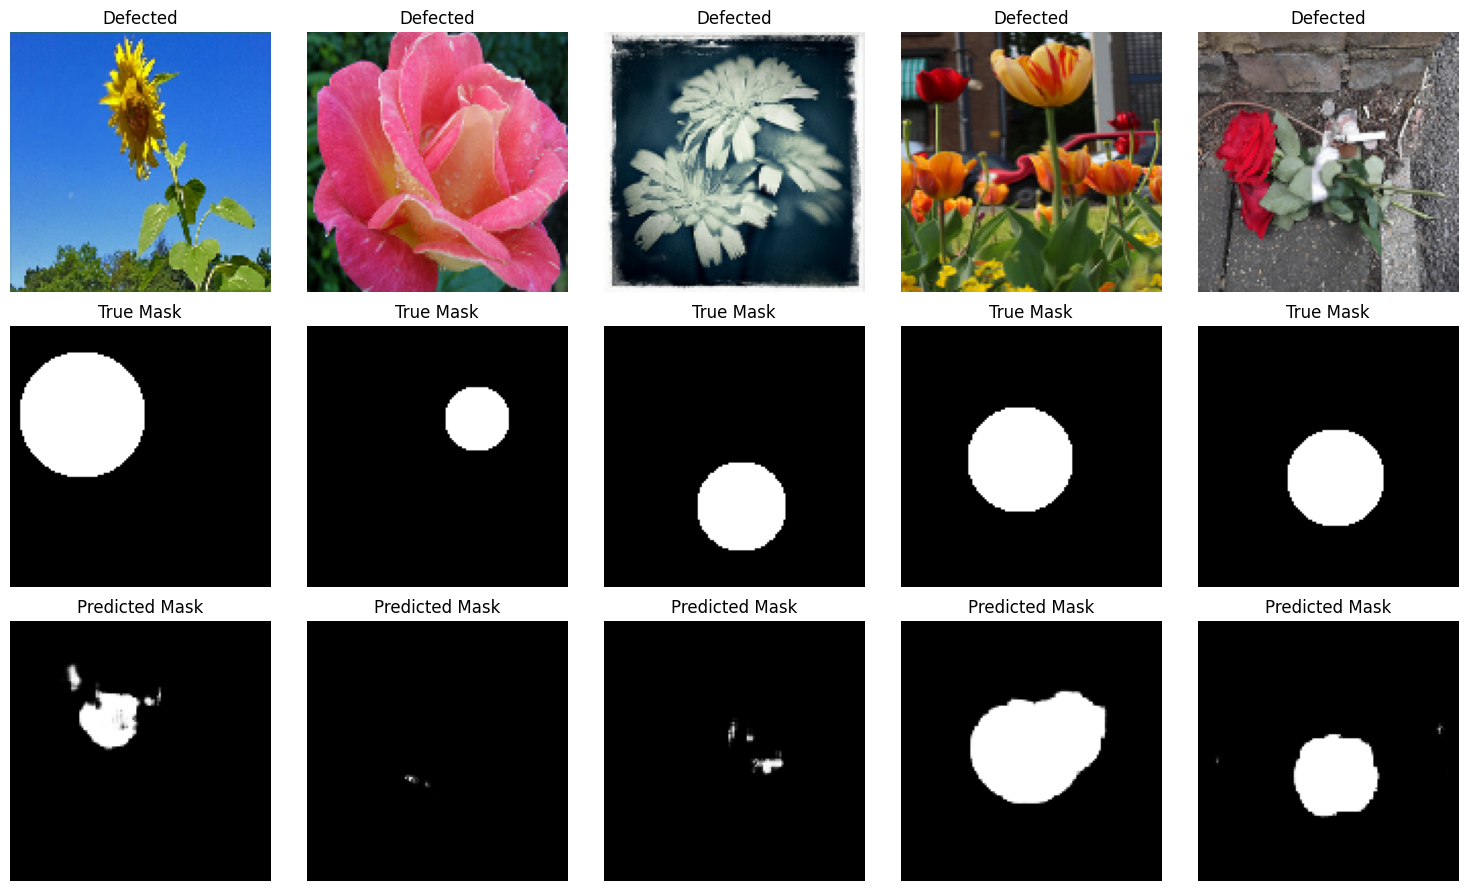

In [15]:
def visualize_mask_predictions(model, data_gen, n=5):
    idx = np.random.randint(0, len(data_gen) - 1)
    imgs, true_masks = data_gen[idx]
    pred_masks = model.predict(imgs)

    plt.figure(figsize=(n * 3, 9))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(imgs[i])
        plt.title("Defected")
        plt.axis("off")

        plt.subplot(3, n, n + i + 1)
        plt.imshow(true_masks[i].squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(3, n, 2 * n + i + 1)
        plt.imshow(pred_masks[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def plot_training_mask(history):
    history_dict = history.history
    metrics = [m for m in history_dict.keys() if not m.startswith("val_")]

    n = len(metrics)
    plt.figure(figsize=(6 * n, 5))

    for i, metric in enumerate(metrics):
        val_metric = "val_" + metric if "val_" + metric in history_dict else None

        plt.subplot(1, n, i + 1)
        plt.plot(history_dict[metric], label=f"Train {metric}")
        if val_metric:
            plt.plot(history_dict[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def compute_segmentation_metrics(
    true_mask, pred_mask, threshold=0.5
):  # threshold for binarization - i used sigmoid activation
    # Binarize predictions
    P = (pred_mask > threshold).astype(np.int32)
    T = (true_mask > 0.5).astype(np.int32)

    # Flatten
    P_flat = P.flatten()
    T_flat = T.flatten()

    # Pixel accuracy
    acc = (P_flat == T_flat).mean()

    # Intersection and Union
    intersection = np.sum(P_flat * T_flat)
    union = np.sum(P_flat) + np.sum(T_flat) - intersection
    iou = intersection / union if union != 0 else 1.0

    # Dice
    dice = (
        2 * intersection / (np.sum(P_flat) + np.sum(T_flat))
        if (np.sum(P_flat) + np.sum(T_flat)) > 0
        else 1.0
    )

    return acc, iou, dice


def evaluate_model(model, data_gen, threshold=0.5):
    """
    Evaluate model over a sequence (data_gen).
    - data_gen: yields (imgs, true_masks) batches.
    """
    accs, ious, dices = [], [], []
    batch_iter = iter(data_gen)

    for step in range(len(data_gen)):
        imgs, true_masks = next(batch_iter)
        pred_masks = model.predict(imgs)

        for tm, pm in zip(true_masks, pred_masks):
            acc, iou, dice = compute_segmentation_metrics(
                tm.squeeze(), pm.squeeze(), threshold
            )
            accs.append(acc)
            ious.append(iou)
            dices.append(dice)

    return {
        "pixel_accuracy": np.mean(accs),
        "mean_IoU": np.mean(ious),
        "mean_Dice": np.mean(dices),
        "std_IoU": np.std(ious),
        "std_Dice": np.std(dices),
    }


metrics = evaluate_model(mask_model, val_seq_maskpredictor)
print("Evaluation results:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

visualize_mask_predictions(mask_model, val_seq_maskpredictor, n=5)

if mask_history is not None:
    plot_training_mask(mask_history)

## Training the Defect Correction Network
This is the training process of the defect correction network.
To adapt the generator to the training process I created a similar wrapper function used in the mask prediction network's training process, but this time the mask is replaced by the predicted mask generated by the mask prediction network.
This way the defect correction network can learn how to correct the defected region based on the mask predicted by the mask prediction network, without the knowledge of the ground truth mask.

I also added some callbacks to the training process:
- **EarlyStopping**: this callback stops the training process if the validation loss does not improve for a certain number of epochs, restoring the best weights.
  - I set the patience to 10 epochs.
- **ReduceLROnPlateau**: this callback reduces the learning rate when a metric has stopped improving.
  - I set the patience to 3 epochs and the factor to 0.95.

In [24]:
# TRAINING DEFECT CORRECTION MODEL
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

TO_TRAIN_CORRECTION_MODEL = True

def wrap_generator_for_fit_correction_model(generator):
    """Wrap to return ((x, mask), clean) for model.fit"""

    class Wrapped(tf.keras.utils.Sequence):
        def __init__(self, base):
            self.base = base

        def __len__(self):
            return len(self.base)

        def __getitem__(self, idx):
            x, mask, clean = self.base[idx]
            # x: (B, H, W, 3), mask: (B, H, W, 1)
            predicted_mask = mask_model(x, training=False)  # Get predicted mask
            return (x, predicted_mask), clean  # model expects 2 inputs

        def on_epoch_end(self):
            self.base.on_epoch_end()

    return Wrapped(generator)


train_seq_defectioncorrection = wrap_generator_for_fit_correction_model(train_gen)
val_seq_defectioncorrection = wrap_generator_for_fit_correction_model(val_gen)

# Add optional callbacks
callbacks_correctionmodel = [
    EarlyStopping(
        patience=10, restore_best_weights=True, monitor="val_loss", verbose=1
    ),
    ReduceLROnPlateau(patience=3, factor=0.95, verbose=1),
]

# Initialize correction history
correction_history = None

# Training Defect Correction Model
if TO_TRAIN_CORRECTION_MODEL:
    print("Training Defect Correction Model...")
    correction_history = correction_model.fit(
        train_seq_defectioncorrection,
        validation_data=val_seq_defectioncorrection,
        epochs=150,
        callbacks=callbacks_correctionmodel,
    )

Lunghezza train_gen: 93
Lunghezza train_seq_defectioncorrection: 93
Train type: <class '__main__.wrap_generator_for_fit_correction_model.<locals>.Wrapped'>
Is instance of Sequence? True
Training Defect Correction Model...


/home/enrico/Desktop/Swirl-Correction/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - loss: 0.0200 - mae: 0.1219 - masked_mae: 0.1632 - mse: 0.0264 - val_loss: 0.0412 - val_mae: 0.1428 - val_masked_mae: 0.2769 - val_mse: 0.0299 - learning_rate: 0.0010
Epoch 2/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - loss: 0.0173 - mae: 0.1125 - masked_mae: 0.1482 - mse: 0.0235 - val_loss: 0.0344 - val_mae: 0.1396 - val_masked_mae: 0.2355 - val_mse: 0.0330 - learning_rate: 0.0010
Epoch 3/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - loss: 0.0193 - mae: 0.1105 - masked_mae: 0.1611 - mse: 0.0223 - val_loss: 0.0262 - val_mae: 0.1325 - val_masked_mae: 0.1688 - val_mse: 0.0338 - learning_rate: 0.0010
Epoch 4/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - loss: 0.0167 - mae: 0.1090 - masked_mae: 0.1413 - mse: 0.0230 - val_loss: 0.0254 - val_mae: 0.1397 - val_masked_mae: 0.1643 - val_mse: 0.0358 - learning_rate: 0.0010
Epoch 5/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - loss: 0.0169 - mae: 0.1072 - masked_mae: 0.1437 - mse: 0

### Saving the model
After training the model, I save the model's weights to a file. This allows me to load the model later without having to retrain it.

In [17]:
TO_SAVE_DEFECT_CORRECTION_MODEL = False

# Save the correction model weights
if TO_SAVE_DEFECT_CORRECTION_MODEL:
    correction_model.save_weights(os.path.join(WEIGHTS_PATH, "correction_model_weights.weights.h5"))
    print(f"Saved correction model weights to {os.path.join(WEIGHTS_PATH, 'correction_model_weights.weights.h5')}")

### Plotting the training history
After training the model, I plot the training and validation loss and metrics over the epochs to visualize the model's performance during the training process.

I also print some predicted results to visually inspect the model's performances.

2025-07-10 09:35:28.252527: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 612 bytes spill stores, 524 bytes spill loads

2025-07-10 09:35:28.295158: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 556 bytes spill stores, 1268 bytes spill loads

2025-07-10 09:35:28.528591: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 608 bytes spill stores, 512 bytes spill loads

2025-07-10 09:35:28.896191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 668 bytes spill stores, 540 bytes spill loads

2025-07-10 09:35:29.360428: I external/loca

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


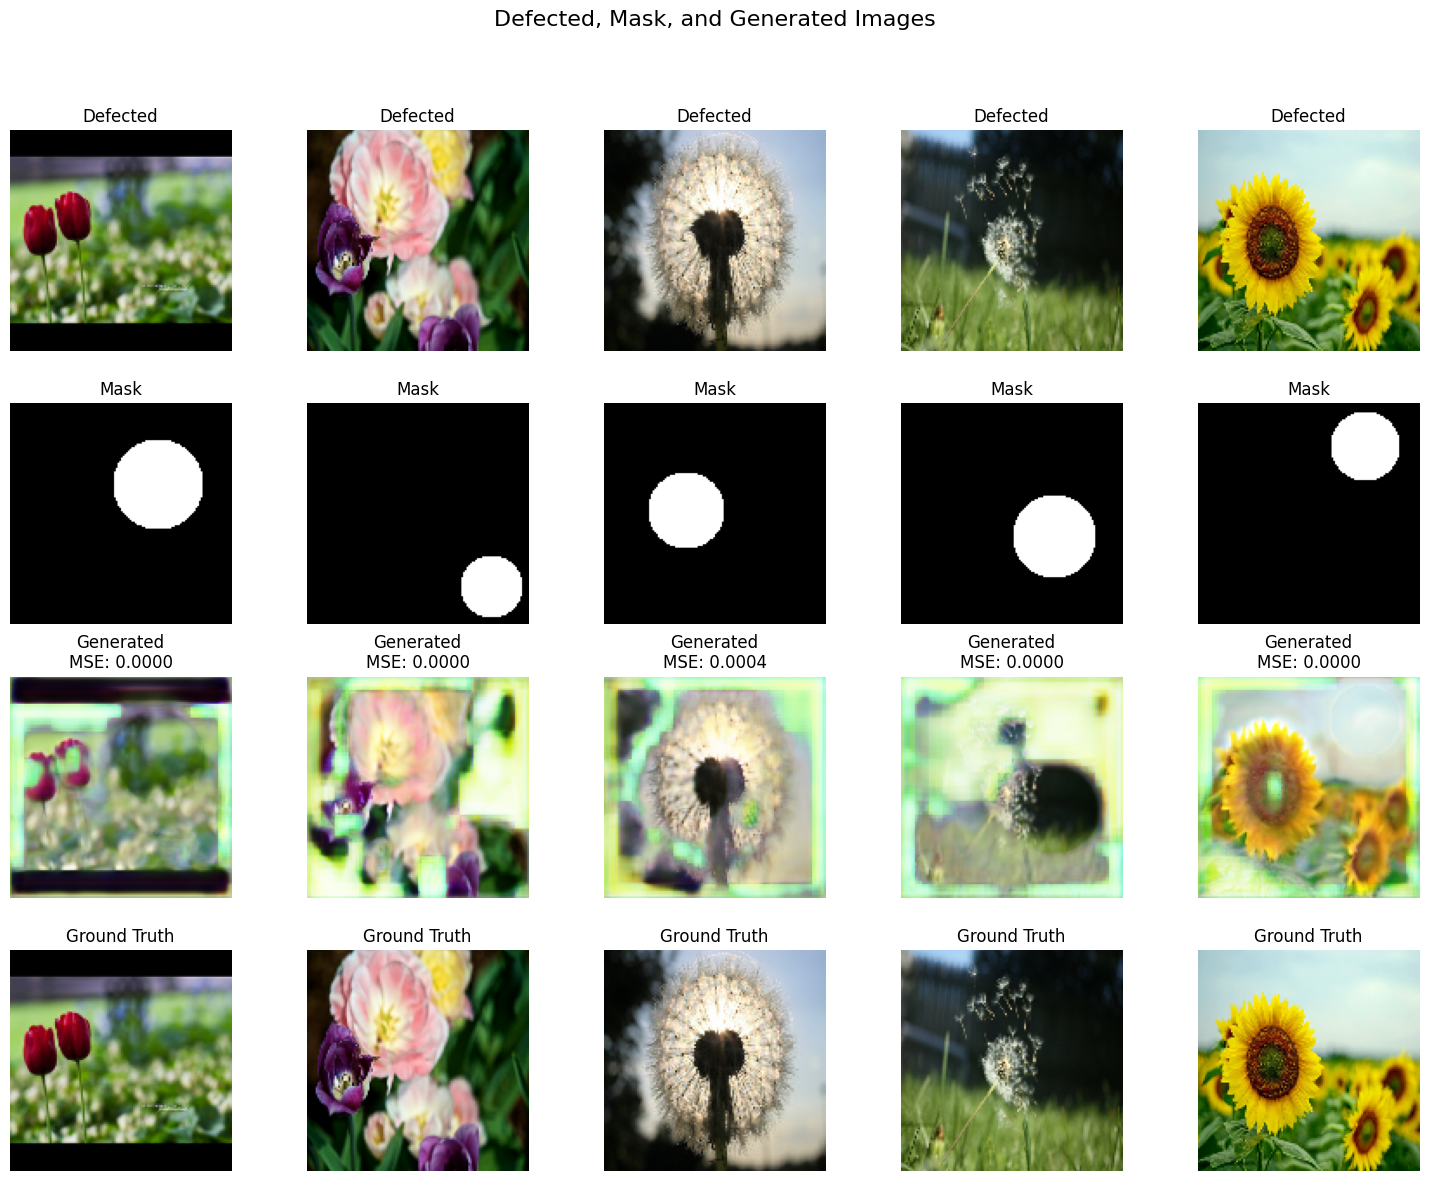

In [18]:
import matplotlib.pyplot as plt
import numpy as np


# Plot loss and MAE
def plot_training_defectedcorrection(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.title("Mean Absolute Error")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Visualization of predictions
def visualize_predictions(model, generator, n_samples=5):
    x_batch, y_mask, y_clean = generator[0]
    generated_images = model.predict([x_batch, y_mask])
    generated_mes_batch = np.mean(
        (generated_images - y_clean) ** 2 * y_mask, axis=(1, 2, 3)
    )

    n_samples = min(n_samples, len(x_batch))  # Clamp to batch size

    plt.figure(figsize=(3 * n_samples, 12))

    for i in range(n_samples):
        # Mask
        plt.subplot(4, n_samples, n_samples + i + 1)
        plt.imshow(y_mask[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        # Defected image
        plt.subplot(4, n_samples, i + 1)
        plt.imshow(x_batch[i])
        plt.title("Defected")
        plt.axis("off")

        # Generated
        plt.subplot(4, n_samples, 2 * n_samples + i + 1)
        plt.imshow(generated_images[i])
        plt.title(f"Generated\nMSE: {generated_mes_batch[i]:.4f}")
        plt.axis("off")

        # Ground Truth (Clean)
        plt.subplot(4, n_samples, 3 * n_samples + i + 1)
        plt.imshow(y_clean[i])
        plt.title("Ground Truth")
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle("Defected, Mask, and Generated Images", fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()


if correction_history is not None:
    # Plot training history
    plot_training_defectedcorrection(correction_history)
    
visualize_predictions(correction_model, val_gen, n_samples=5)

As you may see from the examples, the swirl is not always easily identifiable by a human. The network can locate it quite easily (you may try if you like); the actual challenge consists in correcting the effect.

A pipilene of multiple networks may be acceptable. You should not rely on the knowledge that the defect was due to a swirl.

# Evaluation metric

The generated image should be evaluated ONLY on the region corresponding to the mask. In addition this will be compared with the initial distance introduced by the swirl operation

Let us compute this "initial" error:

In [19]:
# Select a batch from the test generator
idx = np.random.randint(0, len(test_gen) - 1)
x_batch_defected, x_batch_mask, y_batch_clean = test_gen[idx]
# Compute initial distance between swirled image and original for the batch
initial_mse_imgs = np.mean((x_batch_defected - y_batch_clean)**2*x_batch_mask,axis=(1,2,3))
initial_mse_batch = np.mean(initial_mse_imgs)
print(f"Initial error introduced by swilr: {initial_mse_batch:.4f}")

Initial error introduced by swilr: 0.0012


The initial error quite low. To better emphasize the correction we compute the ratio between the resulting error and the initial one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Average score (Generated / Initial): 0.4302


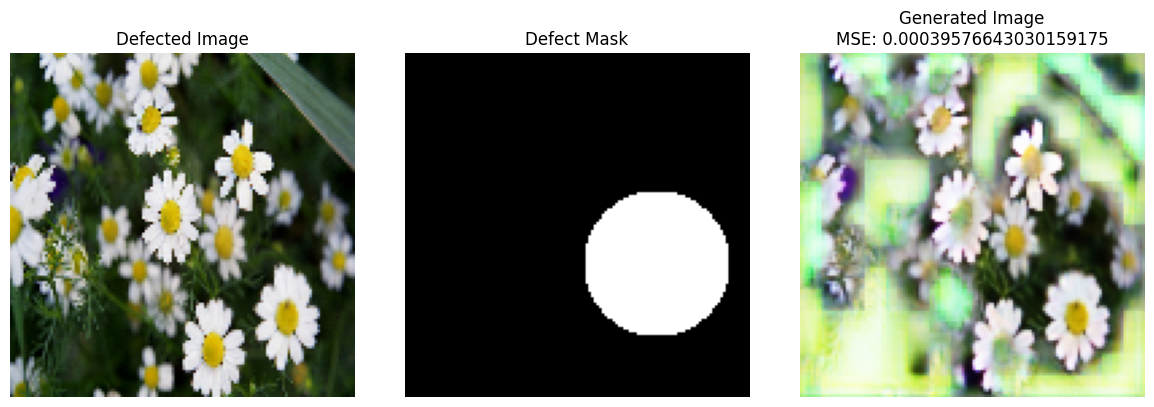

In [20]:
# Predict the repaired images
generated_images = correction_model.predict([x_batch_defected, x_batch_mask])

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean(
    (generated_images - y_batch_clean) ** 2 * x_batch_mask, axis=(1, 2, 3)
)
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch / initial_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

# Visualize the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch_defected[0])
plt.title("Defected Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(x_batch_mask[0].squeeze(), cmap="gray")
plt.title("Defect Mask")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(generated_images[0])
plt.title(f"Generated Image\nMSE: {generated_mes_batch[0]}")
plt.axis("off")
plt.tight_layout()
plt.show()

Repeat the previous computation for all batches in testing data, and return mean and standard deviation.

# Final Evaluation
The final evaluation consists in computing the mean and standard deviation of the ratio between the resulting error and the initial one for all batches in the testing data.
This will give us an idea of how well the model is performing in correcting the defected region in the images.

## Results
The results of the evaluation are as follows:
- **Mean Ratio**: 0.4170
- **Standard Deviation Ratio**: 0.0293

In [22]:
ratios = []

for i in range(len(test_gen)):
    # Extract batch
    x_def, x_mask, y_clean = test_gen[i]

    # Initial MSE for each image (only masked region)
    initial_mse_imgs = np.mean((x_def - y_clean) ** 2 * x_mask, axis=(1, 2, 3))
    initial_mse_batch = initial_mse_imgs.mean()

    # Predict repaired images
    gen = correction_model.predict([x_def, x_mask], verbose=0)

    # MSE for generated images (only masked region)
    gen_mse_imgs = np.mean((gen - y_clean) ** 2 * x_mask, axis=(1, 2, 3))

    # Ratio batch-wise
    mean_ratio = gen_mse_imgs.mean() / initial_mse_batch
    ratios.append(mean_ratio)

ratios = np.array(ratios)
print(f"Mean ratio       = {ratios.mean():.4f}")
print(f"Std. deviation   = {ratios.std():.4f}")

Mean ratio       = 0.4170
Std. deviation   = 0.0293


# Parameters

Try to keep below 4M parameters (total, excluding parameteres of the optimizer).

You have the usual constraints:
* the project should be written in keras
* you should submit a single well documented notebook
* try to give access to weights through gdown


